<a href="https://colab.research.google.com/github/timothy2077/1st-Rep/blob/master/Exploration_Project_A_081224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1. 데이터셋 내려받기

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

# tf_flowers 데이터셋 다운로드
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


### Step 2. 데이터셋을 모델에 넣을 수 있는 형태로 준비하기

In [2]:
# 데이터셋 분할
train_dataset, validation_dataset, test_dataset = tfds.load('tf_flowers', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised=True)

# 이미지 크기 조정 및 배치 처리
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train_batches = train_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)


print(info)


tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/incomplete.HCOQU4_3.0.1/',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


### Step 3. 모델 설계하기 & Step 4. 모델 학습시키기 A

1. MobileNetV2를 사전 학습된 base_model로 사용하여 tf_flowers 데이터셋을 분류하는 모델을 만들자
2. 마지막 Dense 레이어의 출력 노드 수를 5로 설정하여 5개의 클래스를 분류할 수 있는 모델을 만들자
3. 모델을 컴파일하고 학습한 후 테스트 데이터셋으로 평가하는 모델을 만들자
4. 옵티마이저는 Adam, 손실함수는 Sparse Categorical Crossentropy, 지표는 Accuracy를 사용하자

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models

# tf_flowers 데이터셋 다운로드 및 분할
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
train_dataset, validation_dataset, test_dataset = tfds.load('tf_flowers', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised=True)

# 이미지 크기 조정 및 배치 처리
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

train_batches = train_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_dataset.map(format_image).batch(BATCH_SIZE).prefetch(1)

# 사전 학습된 모델 로드
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# 모델 아키텍처 정의
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # tf_flowers 데이터셋의 클래스 수는 5개
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습
history = model.fit(train_batches,
                    validation_data=validation_batches,
                    epochs=10)

# 모델 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f'Test accuracy: {test_acc}')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 663s 8s/step - accuracy: 0.6912 - loss: 0.9054 - val_accuracy: 0.2995 - val_loss: 30.3632
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 565s 7s/step - accuracy: 0.8608 - loss: 0.4365 - val_accuracy: 0.4682 - val_loss: 11.8683
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 604s 7s/step - accuracy: 0.8863 - loss: 0.3253 - val_accuracy: 0.2868 - val_loss: 32.0260
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 561s 7s/step - accuracy: 0.9017 - loss: 0.2868 - val_accuracy: 0.3140 - val_loss: 36.4350
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 539s 7s/step - accuracy: 0.9303 - loss: 0.2277 - val_accuracy: 0.3884 - val_loss: 16.3601
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 535s 7s/step - accuracy: 0.9283 - loss: 0.2436 - val_accuracy: 0.4428 - val_loss: 15.0502
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 560s 7s/step - accuracy: 0.9385 - loss: 0.2079 - val_accuracy: 0.2541 - val_loss: 11.5538
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 576s 7s/step - ac

### Step 4. 변경된 모델로 학습시키기 B (이미 학습시킨 모델 A를 변형하고 튜닝해서 Val_Accuray를 향상시키자)

1. 새로운 옵티마이저와 손실 함수 설정: Adam에서 RMSprop으로 변경하고 sparse_categorical_crossentropy에서 categorical_crossentropy로 변경하자

2. Epochs: 10에서 5로 변경(부득이하게 훈련시간 단축을 위해.....)하자
3. Batch Normalization: GlobalAveragePooling2D 레이어 뒤에 BatchNormalization 레이어를 추가하자
4. one_hot_encode_and_format을 사용하여 이미지를 전처리하고 라벨을 원-핫 인코딩하자
5. .map() 메서드를 사용하여 각 데이터셋(train_batches, validation_batches, test_batches)에 대해 위의 one_hot_encode_and_format을 적용하여 라벨을 원-핫 인코딩하고 이미지를 전처리하자
6. prefetch(tf.data.experimental.AUTOTUNE)를 사용하여 데이터 로드 속도를 높이기 위해 prefetch를 최적화하자
7. learning rate를 0.0001로 설정하자


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# tf_flowers 데이터셋 다운로드 및 분할
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
train_dataset, validation_dataset, test_dataset = tfds.load('tf_flowers', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised=True)

# 이미지 크기 조정 및 배치 처리
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# 타겟 데이터 원-핫 인코딩 및 이미지 형식 지정
def one_hot_encode_and_format(image, label):
    image, label = format_image(image, label)
    label = to_categorical(label, num_classes=5)
    return image, label

# 데이터셋에 원-핫 인코딩 및 전처리 적용
train_batches = train_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 사전 학습된 모델 로드 (예: MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# 모델 아키텍처 정의
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # tf_flowers 데이터셋의 클래스 수는 5개
])

# 새로운 옵티마이저와 손실 함수 설정
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
loss = 'categorical_crossentropy'

# 모델 컴파일
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

# 모델 학습
history = model.fit(train_batches,
                    validation_data=validation_batches,
                    epochs=5)

# 모델 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f'Test accuracy: {test_acc}')


Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 637s 8s/step - accuracy: 0.6303 - loss: 0.9870 - val_accuracy: 0.7931 - val_loss: 0.5641
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 546s 7s/step - accuracy: 0.9477 - loss: 0.1539 - val_accuracy: 0.8367 - val_loss: 0.4755
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 577s 7s/step - accuracy: 0.9863 - loss: 0.0422 - val_accuracy: 0.8711 - val_loss: 0.4938
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 584s 7s/step - accuracy: 0.9978 - loss: 0.0112 - val_accuracy: 0.8748 - val_loss: 0.4697
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 544s 7s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.8784 - val_loss: 0.4842
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9033 - loss: 0.4072
Test accuracy: 0.8963636159896851


### Step 5. 모델 성능 평가하기 A
1. 모델 학습 과정의 정확도와 손실을 시각화하기
####**원칙적인 실행이지만 긴 훈련 소요시간으로 인해 하기 B & C로 우선 실행하고 마지막 Step 6. 모델 활용하기에서 최종적으로 수행하자**


In [ ]:
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# tf_flowers 데이터셋 다운로드 및 분할
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
train_dataset, validation_dataset, test_dataset = tfds.load('tf_flowers', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised=True)

# 이미지 크기 조정 및 배치 처리
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# 타겟 데이터 원-핫 인코딩 및 이미지 형식 지정
def one_hot_encode_and_format(image, label):
    image, label = format_image(image, label)
    label = to_categorical(label, num_classes=5)
    return image, label

# 데이터셋에 원-핫 인코딩 및 전처리 적용
train_batches = train_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 사전 학습된 모델 로드 (예: MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# 모델 아키텍처 정의
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # tf_flowers 데이터셋의 클래스 수는 5개
])

# 새로운 옵티마이저와 손실 함수 설정
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
loss = 'categorical_crossentropy'

# 모델 컴파일
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

# 모델 학습
history = model.fit(train_batches,
                    validation_data=validation_batches,
                    epochs=5)

# 모델 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f'Test accuracy: {test_acc}')

# 학습 과정 시각화
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(history)

# 테스트 데이터에 대한 예측 결과 확인
def plot_predictions(model, test_batches):
    class_names = info.features['label'].names
    plt.figure(figsize=(15, 15))

    for images, labels in test_batches.take(1):
        predictions = model.predict(images)
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(f"Pred: {class_names[tf.argmax(predictions[i])]}, True: {class_names[tf.argmax(labels[i])]}")
            plt.axis('off')

    plt.show()

plot_predictions(model, test_batches)


### Step 5. 모델 성능 평가하기 B

2. 테스트 데이터에 대한 예측 결과를 확인하기

#### Step 4의 결과(학습 결과)를 history 딕셔너리로 활용하여 실제 모델의 재훈련 없이도 시각화가 가능하도록 구현하자

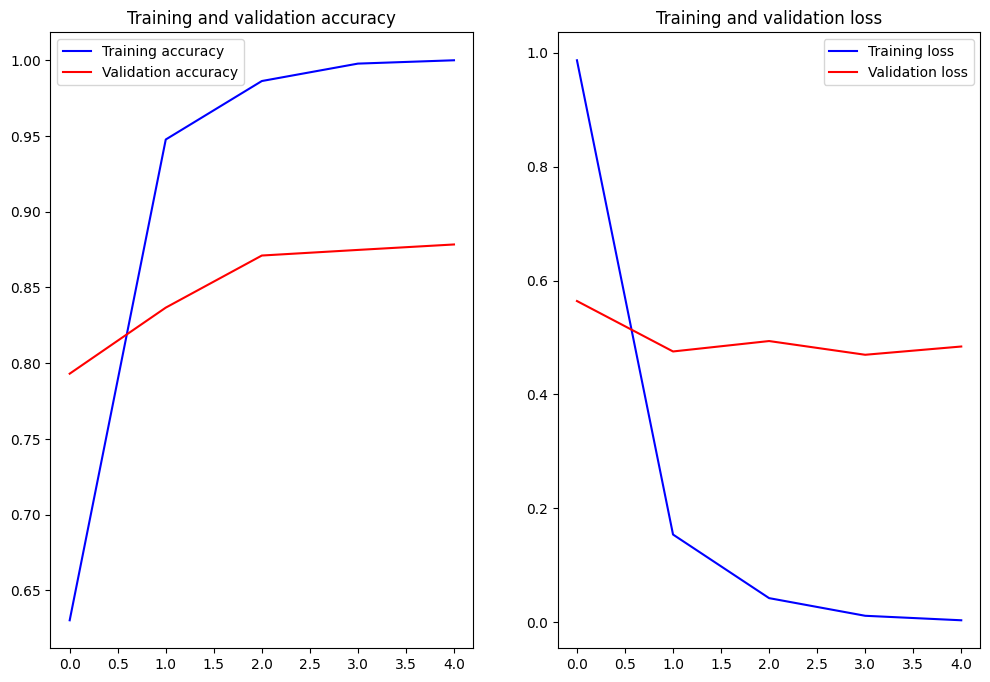

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf

# 학습 과정 시각화 함수
def plot_training_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# 테스트 데이터에 대한 예측 결과 확인 함수
def plot_predictions(model, test_batches, info):
    class_names = info.features['label'].names
    plt.figure(figsize=(15, 15))

    for images, labels in test_batches.take(1):
        predictions = model.predict(images)
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            predicted_label = tf.argmax(predictions[i])
            true_label = tf.argmax(labels[i])
            plt.title(f"Pred: {class_names[predicted_label]}, True: {class_names[true_label]}")
            plt.axis('off')

    plt.show()

# 제공된 학습 결과를 사용하여 시각화
history = {
    'accuracy': [0.6303, 0.9477, 0.9863, 0.9978, 1.0000],
    'val_accuracy': [0.7931, 0.8367, 0.8711, 0.8748, 0.8784],
    'loss': [0.9870, 0.1539, 0.0422, 0.0112, 0.0033],
    'val_loss': [0.5641, 0.4755, 0.4938, 0.4697, 0.4842]
}

# 학습 과정 시각화
plot_training_history(history)



### Step 5. 모델 성능 평가하기 C
#### validation_batches나 test_batches에 있는 데이터에 대한 예측 결과도 확인하자

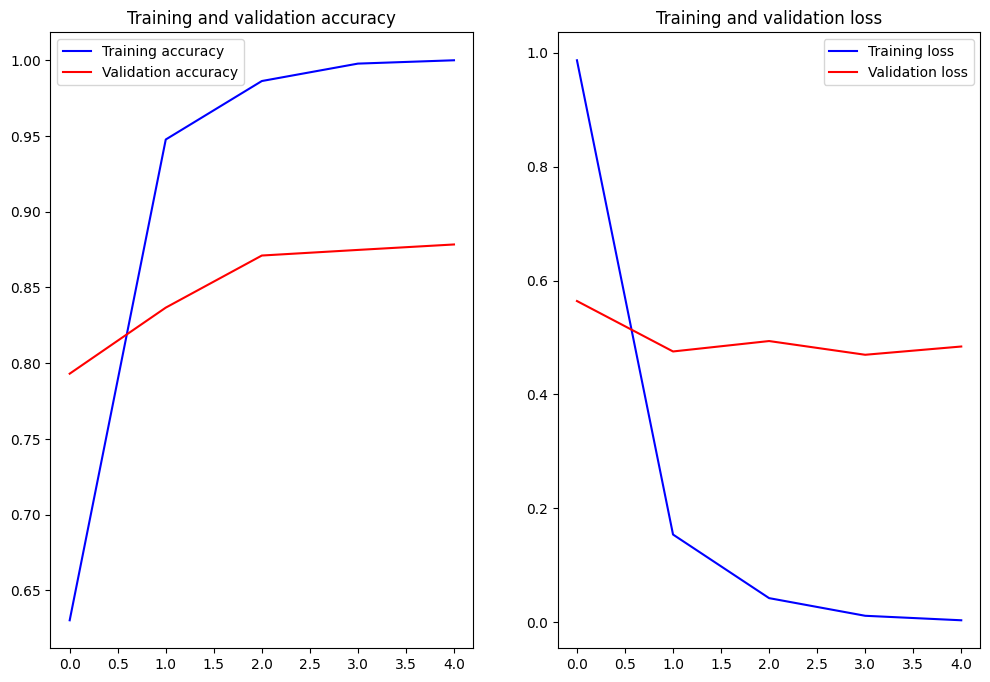

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


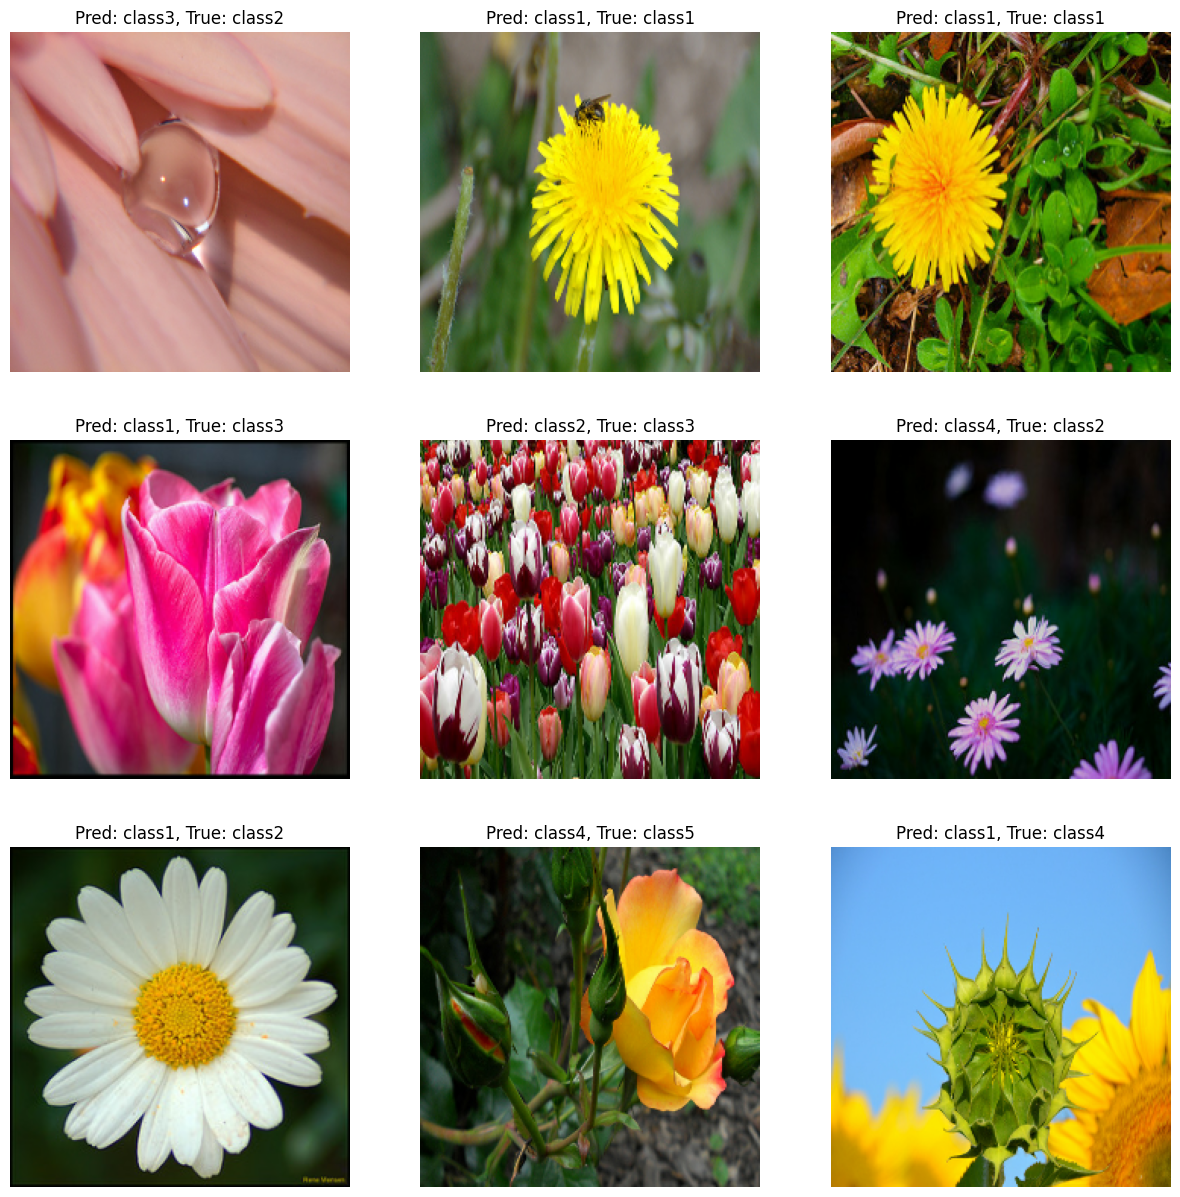

In [13]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
def plot_training_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# 테스트 데이터에 대한 예측 결과 확인
def plot_predictions(model, test_batches, class_names):
    plt.figure(figsize=(15, 15))

    for images, labels in test_batches.take(1):
        predictions = model.predict(images)
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(f"Pred: {class_names[tf.argmax(predictions[i])]}, True: {class_names[tf.argmax(labels[i])]}")
            plt.axis('off')

    plt.show()

# 학습 과정 시각화 호출
plot_training_history(history)  # Pass 'history' directly

# 클래스 이름 정의
class_names = ['class1', 'class2', 'class3', 'class4', 'class5']

# 테스트 데이터에 대한 예측 결과 확인 호출
plot_predictions(model, test_batches, class_names)


### Step 6. 모델 활용하기
####**꽃 10종류와 고양이 10종류를 무작위로 모델에 입력하고 예측 결과를 시각화하는 기능을 추가한 후 모델의 예측결과를 확인하자**

Epoch 1/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 646s 7s/step - accuracy: 0.6617 - loss: 0.9613 - val_accuracy: 0.8221 - val_loss: 0.5334
Epoch 2/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 548s 7s/step - accuracy: 0.9492 - loss: 0.1468 - val_accuracy: 0.8475 - val_loss: 0.4837
Epoch 3/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 533s 7s/step - accuracy: 0.9951 - loss: 0.0343 - val_accuracy: 0.8058 - val_loss: 0.7970
Epoch 4/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 549s 6s/step - accuracy: 0.9994 - loss: 0.0110 - val_accuracy: 0.7913 - val_loss: 0.9544
Epoch 5/5
81/81 ━━━━━━━━━━━━━━━━━━━━ 547s 6s/step - accuracy: 0.9997 - loss: 0.0084 - val_accuracy: 0.8584 - val_loss: 0.7106
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8683 - loss: 0.6717
Test accuracy: 0.8690909147262573


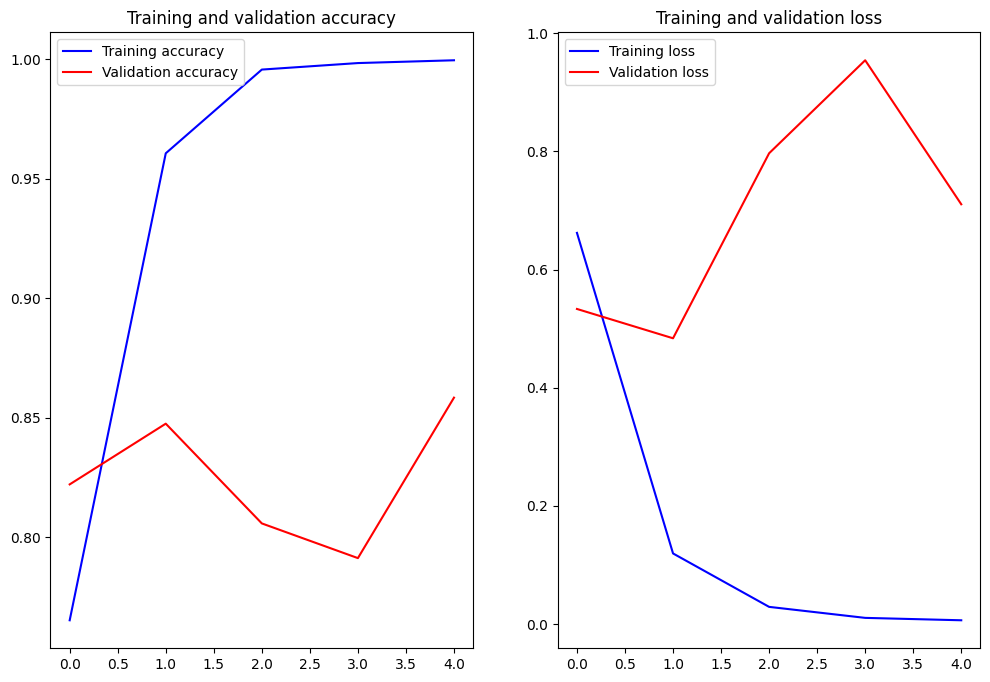

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


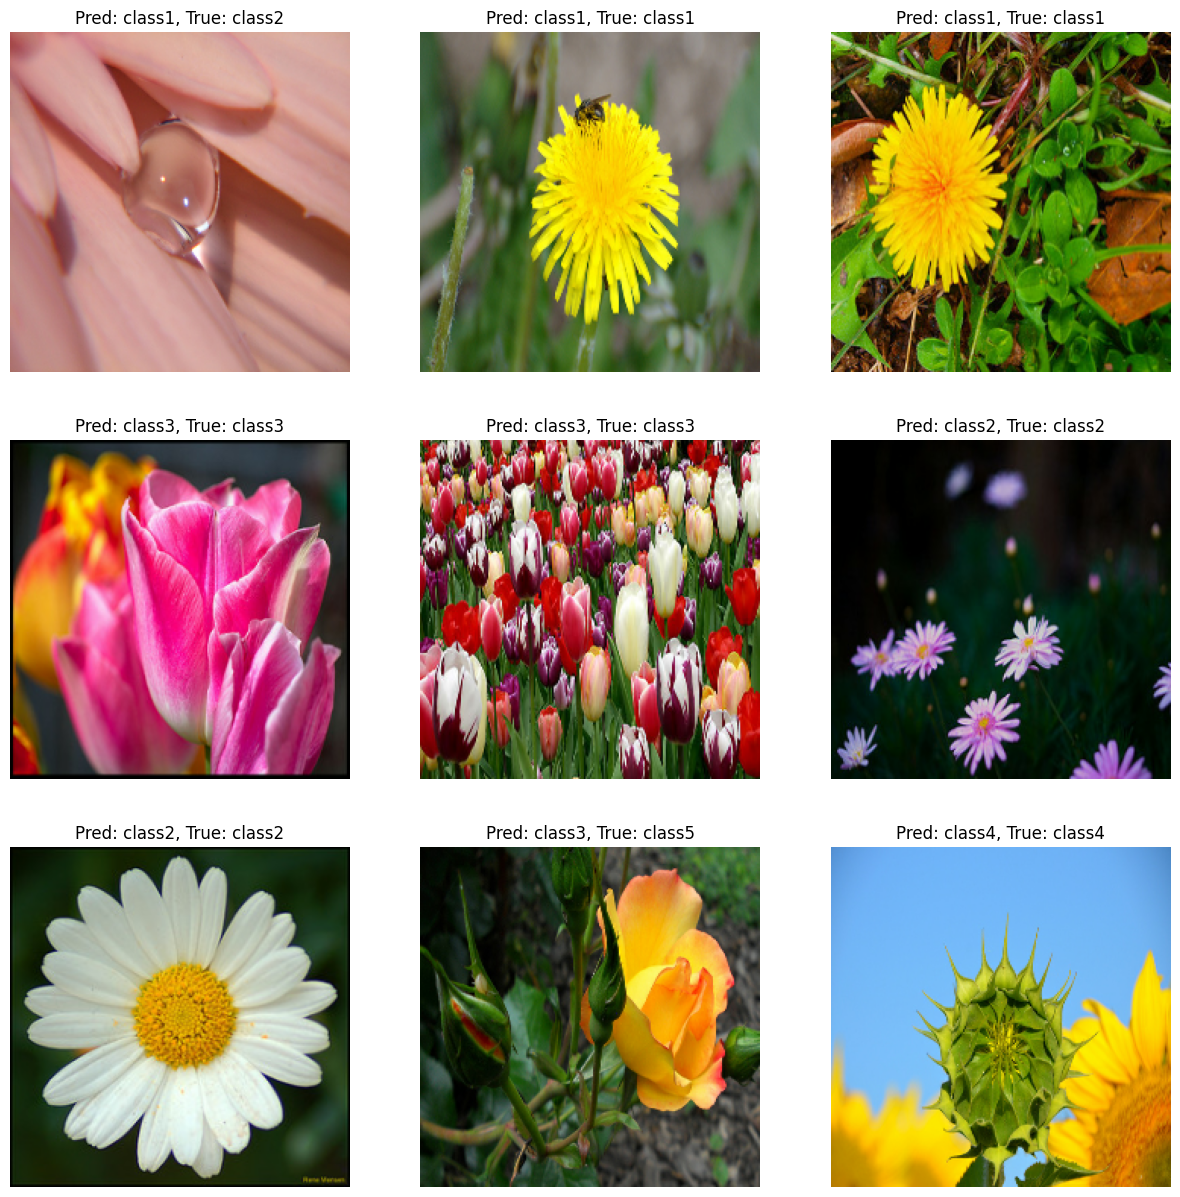

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.C495QS_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.C495QS_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


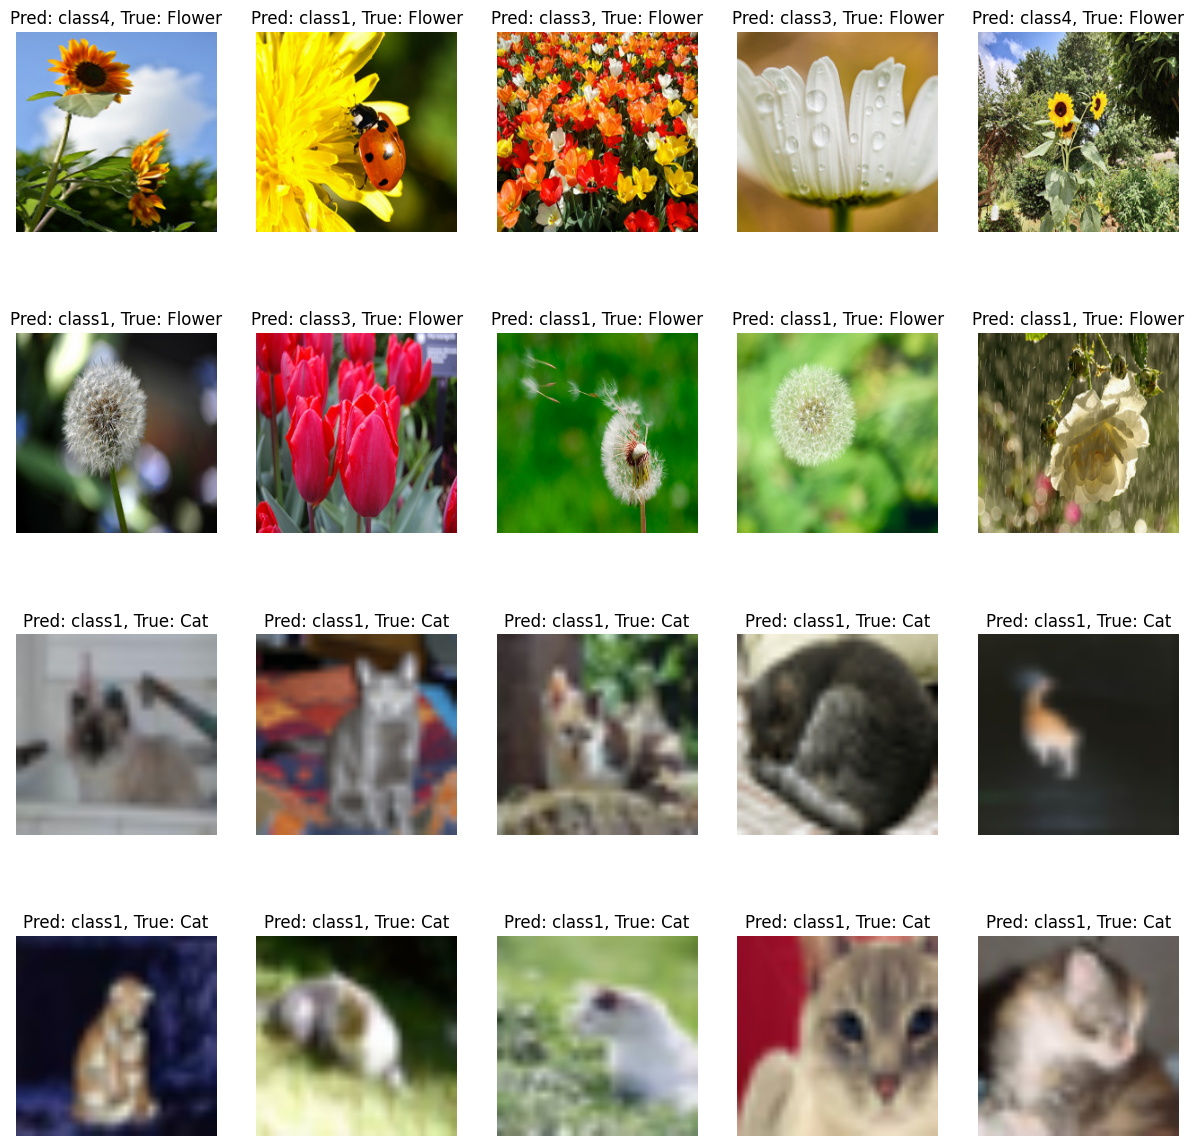

In [14]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# tf_flowers 데이터셋 다운로드 및 분할
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
train_dataset, validation_dataset, test_dataset = tfds.load('tf_flowers', split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised=True)

# 이미지 크기 조정 및 배치 처리
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# 타겟 데이터 원-핫 인코딩 및 이미지 형식 지정
def one_hot_encode_and_format(image, label):
    image, label = format_image(image, label)
    label = to_categorical(label, num_classes=5)
    return image, label

# 데이터셋에 원-핫 인코딩 및 전처리 적용
train_batches = train_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_batches = validation_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_batches = test_dataset.map(one_hot_encode_and_format).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# 사전 학습된 모델 로드 (예: MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               include_top=False,
                                               weights='imagenet')

# 모델 아키텍처 정의
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')  # tf_flowers 데이터셋의 클래스 수는 5개
])

# 새로운 옵티마이저와 손실 함수 설정
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
loss = 'categorical_crossentropy'

# 모델 컴파일
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

# 모델 학습
history = model.fit(train_batches,
                    validation_data=validation_batches,
                    epochs=5)

# 모델 평가
test_loss, test_acc = model.evaluate(test_batches)
print(f'Test accuracy: {test_acc}')

# 학습 과정 시각화
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# 테스트 데이터에 대한 예측 결과 확인
def plot_predictions(model, test_batches, class_names):
    plt.figure(figsize=(15, 15))

    for images, labels in test_batches.take(1):
        predictions = model.predict(images)
        for i in range(9):
            plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(f"Pred: {class_names[tf.argmax(predictions[i])]}, True: {class_names[tf.argmax(labels[i])]}")
            plt.axis('off')

    plt.show()

# 학습 과정 시각화 호출
plot_training_history(history)

# 클래스 이름 정의
class_names = ['class1', 'class2', 'class3', 'class4', 'class5']

# 테스트 데이터에 대한 예측 결과 확인 호출
plot_predictions(model, test_batches, class_names)

# 꽃 10종류와 고양이 10종류를 무작위로 모델에 입력하여 예측 결과 확인
def plot_random_predictions(model, class_names):
    # 꽃 이미지 10개 무작위 선택
    flower_images, _ = next(iter(test_batches.unbatch().shuffle(1000).batch(10)))
    # 고양이 이미지 10개 무작위 선택 (예시로 CIFAR-10 데이터셋 사용)
    cifar10_dataset = tfds.load('cifar10', split='test', as_supervised=True)
    cat_images = []
    for image, label in cifar10_dataset:
        if label == 3:  # CIFAR-10에서 고양이 클래스는 3번
            cat_images.append(image)
        if len(cat_images) == 10:
            break
    cat_images = tf.stack(cat_images)
    cat_images = tf.image.resize(cat_images, (IMG_SIZE, IMG_SIZE)) / 255.0

    # 꽃과 고양이 이미지 합치기
    combined_images = tf.concat([flower_images, cat_images], axis=0)

    # 예측
    predictions = model.predict(combined_images)

    plt.figure(figsize=(15, 15))
    for i in range(20):
        plt.subplot(4, 5, i + 1)
        plt.imshow(combined_images[i])
        plt.title(f"Pred: {class_names[tf.argmax(predictions[i])]}, True: {'Flower' if i < 10 else 'Cat'}")
        plt.axis('off')

    plt.show()

# 꽃과 고양이 예측 결과 확인 호출
plot_random_predictions(model, class_names)
